In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv("raw_data.csv")

In [4]:
df.describe(include="all")

,Precio,NCuartos,Area,NBaños,Distrito,Amoblado,Mantenimiento,Cochera,Azotea
count,4266.000000,4216.000000,4132.000000,4124.000000,4243,1703,1260.000000,871.000000,4267
unique,NaN,NaN,NaN,NaN,41,4,NaN,NaN,2
top,NaN,NaN,NaN,NaN,Miraflores,Amoblado: Sin amoblar,NaN,NaN,no
freq,NaN,NaN,NaN,NaN,1317,791,NaN,NaN,4048
mean,2818.848865,2.430503,121.424976,2.225752,NaN,NaN,314.865873,1.454650,NaN
std,27549.283309,0.902565,85.628266,0.977906,NaN,NaN,198.622341,0.711126,NaN
min,0.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN
25%,581.655000,2.000000,72.000000,2.000000,NaN,NaN,180.000000,1.000000,NaN
50%,806.110000,3.000000,98.000000,2.000000,NaN,NaN,290.000000,1.000000,NaN
75%,1250.000000,3.000000,140.000000,3.000000,NaN,NaN,420.000000,2.000000,NaN


In [5]:
df_clean = df.copy()

# Tratamiento de Nulos

## Amoblado:

- NAN -> 0
- Sin Amoblar -> 0
- Semi-amoblado -> 1
- Amoblado -> 2

In [6]:
df_clean["Amoblado"].value_counts(dropna=False)

NaN                        2564
Amoblado: Sin amoblar       791
Amoblado: Amoblado          756
Amoblado: Semi-amoblado     149
Amoblado                      7
Name: Amoblado, dtype: int64

In [7]:
df_clean["Amoblado"] = df_clean["Amoblado"].str.replace("Amoblado:", "").str.strip()

In [8]:
def limpiar_amoblado(row):
    if row is None or row == "Sin amoblar":
        row = 0
    elif row == "Semi-amoblado":
        row = 1
    elif row == "Amoblado":
        row = 2
    return row 
df_clean["Amoblado"] = df_clean["Amoblado"].apply(limpiar_amoblado)
df_clean["Amoblado"] = df_clean["Amoblado"].replace(np.nan, 0)

## Azotea

In [9]:
df_clean["Azotea"] = df_clean["Azotea"].apply(lambda x: 1 if x=="si" else 0)
df_clean["Azotea"]

0       0
1       0
2       1
3       0
4       0
       ..
4262    0
4263    0
4264    0
4265    0
4266    0
Name: Azotea, Length: 4267, dtype: int64

## Cochera

In [10]:
df_clean["Cochera"] = df_clean["Cochera"].replace(np.nan, 0)

## Precio
- Precio
- NCuartos
- Area
- Distrito
- NBaños

Numero total de filas antes: 4266

Numero total de filas despues: 3953

Se reduce un 7.3% del total de datos

In [11]:
df_clean.dropna(subset=["Precio", "NCuartos", "Area", "Distrito", "NBaños"], axis=0, inplace=True)

Eliminamos la columna "Mantenimiento", ya que el numero de valores Nulos es mayor al 50% del total.

In [12]:
df_clean.dropna(axis=1, inplace=True)

Reiniciamos el index del DataFrame, ya que al limpiar los datos se eliminan filas pero el numero de las filas se queda intacto. 

In [13]:
df_clean.reset_index(drop=True, inplace=True)

En la siguiente lista podemos visualizar que ya no quedan valores nulos en las columnas:

In [14]:
df_clean.isnull().sum()

Precio      0
NCuartos    0
Area        0
NBaños      0
Distrito    0
Amoblado    0
Cochera     0
Azotea      0
dtype: int64

In [15]:
df_test = df_clean.copy()

# Tratamiento Outliers

## Precio 

Primero vamos a tratar la columna "Precio". En el siguiente grafico podemos ver la distribucion de los valores de esta. Se pueden visualizar los outliers en el grafico como circulos vacios:

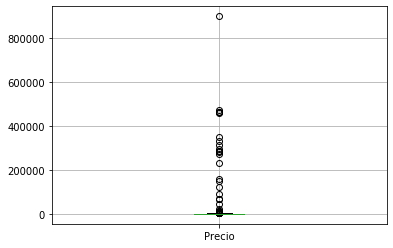

In [16]:
df_clean.boxplot("Precio")
plt.title("")
plt.show()

Distribucion de los valores de la columna "Precio":

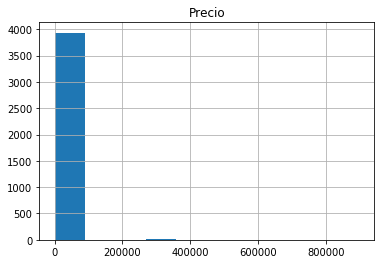

In [17]:
df_clean.hist("Precio")
plt.show()

Vemos las estadisticas de la columna "Precio" para ver cuales son los valores de los cuartiles inferior y superior.

In [18]:
df_clean["Precio"].describe()

count      3953.000000
mean       2737.619656
std       26304.436384
min           0.000000
25%         583.740000
50%         830.000000
75%        1250.000000
max      897843.100000
Name: Precio, dtype: float64

Eliminamos las filas que tienen como precio igual a 0:

In [19]:
df_clean = df_clean[df_clean["Precio"] > 0]

Para limpiar los outliers, aplicamos la formula del rango intercuartil:

- Rango Intercuartil = Cuartil Superior - Cuartil Inferior

Luego, calculamos los limites inferior y superior, los valores que se encuentren fuera de este limites son atipicos y seran eliminados.

In [20]:
rango_intercuartil = df_clean["Precio"].describe()[6] - df_clean["Precio"].describe()[4] 
limite_superior = df_clean["Precio"].describe()[6]  + rango_intercuartil*1.5
limite_inferior = df_clean["Precio"].describe()[4] - rango_intercuartil*1.5
if limite_inferior < 0:
    limite_inferior = 0
print("Valor del Limite inferior ", limite_inferior)
print("Valor del Limite superior ", limite_superior)

Valor del Limite inferior  0
Valor del Limite superior  2228.54


Los valores que se encuentran entre 0 y 2249.39 seran eliminados. De esta forma, se eliminaran 318 filas.

In [21]:
df_clean[df_clean["Precio"] >= 2249.39].count()

Precio      318
NCuartos    318
Area        318
NBaños      318
Distrito    318
Amoblado    318
Cochera     318
Azotea      318
dtype: int64

In [22]:
df_clean = df_clean[df_clean["Precio"] <= 2249.39]

Verificamos cuales son los nuevos outliers:

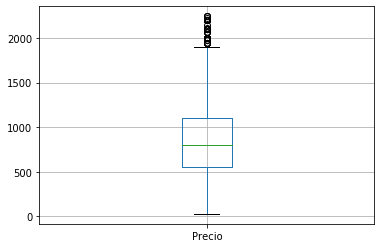

In [23]:
df_clean.boxplot("Precio")
plt.show()

La nueva distribucion de la columna "Precio":

In [24]:
df_clean[df_clean.Precio == 0].count()

Precio      0
NCuartos    0
Area        0
NBaños      0
Distrito    0
Amoblado    0
Cochera     0
Azotea      0
dtype: int64

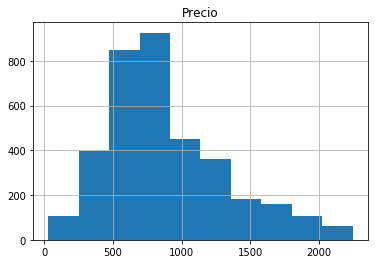

In [25]:
df_clean.hist("Precio")
plt.show()

## Numero Baños

Ahora eliminaremos los valores outliers en la columna "NBaños"

In [26]:
df_clean["NBaños"].value_counts()

2.0    1603
1.0     880
3.0     739
4.0     227
2.5      74
1.5      26
3.5      24
5.0      22
6.0       3
4.5       2
Name: NBaños, dtype: int64

In [27]:
df_clean["NBaños"].describe()

count    3600.000000
mean        2.126667
std         0.883101
min         1.000000
25%         1.500000
50%         2.000000
75%         3.000000
max         6.000000
Name: NBaños, dtype: float64

Aplicando la formula de Rango Intercuartil, calculamos el limite inferior y superior, y eliminamos los valores atipicos de esta columna:

In [28]:
rango_intercuartil = df_clean["NBaños"].describe()[6] - df_clean["NBaños"].describe()[4] 
limite_superior = df_clean["NBaños"].describe()[6]  + rango_intercuartil*1.5
limite_inferior = df_clean["NBaños"].describe()[4] - rango_intercuartil*1.5
if limite_inferior < 0:
    limite_inferior = 0
print("Valor del Limite inferior ", limite_inferior)
print("Valor del Limite superior ", limite_superior)

# Eliminamos outliers:
df_clean = df_clean[df_clean["NBaños"] <= 5]

Valor del Limite inferior  0
Valor del Limite superior  5.25


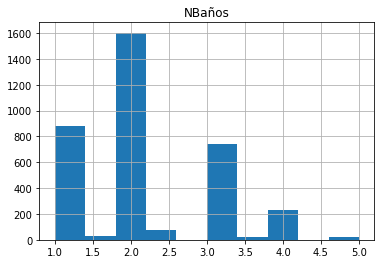

In [29]:
df_clean.hist("NBaños")
plt.show()

## Numero Cuartos

Revisa

1.0     680
2.0    1137
3.0    1616
4.0     150
5.0       8
6.0       4
7.0       2
Name: NCuartos, dtype: int64


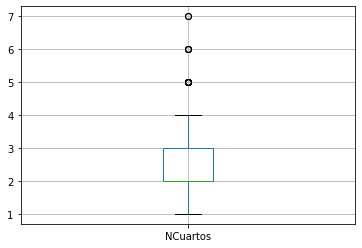

In [30]:
print(df_clean["NCuartos"].value_counts().sort_index())
df_clean.boxplot("NCuartos")
plt.show()

In [31]:
rango_intercuartil = df_clean["NCuartos"].describe()[6] - df_clean["NCuartos"].describe()[4] 
limite_superior = df_clean["NCuartos"].describe()[6]  + rango_intercuartil*1.5
limite_inferior = df_clean["NCuartos"].describe()[4] - rango_intercuartil*1.5
print("Valor del Limite inferior ", limite_inferior)
print("Valor del Limite superior ", limite_superior)

Valor del Limite inferior  0.5
Valor del Limite superior  4.5


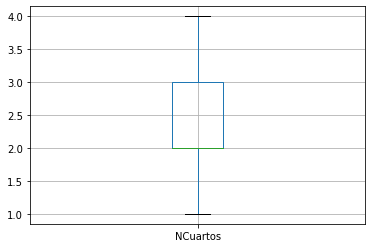

In [32]:
# Eliminamos outliers:
df_clean = df_clean[df_clean.NCuartos <= 4.5]
df_clean.boxplot("NCuartos")

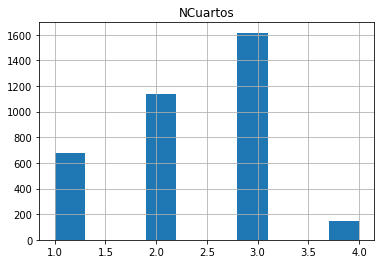

In [33]:
df_clean.hist("NCuartos")
plt.show()

# Cochera

In [34]:
df.Cochera.value_counts()

1.0     547
2.0     269
3.0      46
4.0       6
5.0       2
10.0      1
Name: Cochera, dtype: int64

In [35]:
df.Cochera.describe()[6]
df.Cochera.describe()[4]

1.0

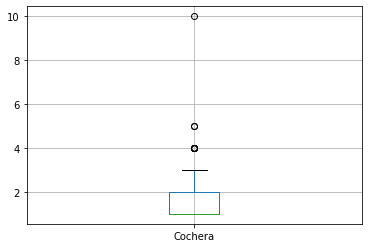

In [36]:
df.boxplot("Cochera")

In [37]:
rango_intercuartil = df.Cochera.describe()[6] - df.Cochera.describe()[4]
limite_superior = df.Cochera.describe()[6]  + rango_intercuartil*1.5
limite_inferior = df.Cochera.describe()[4] - rango_intercuartil*1.5
if limite_inferior < 0:
    limite_inferior = 0
print("Valor del Limite inferior ", limite_inferior)
print("Valor del Limite superior ", limite_superior) 

Valor del Limite inferior  0
Valor del Limite superior  3.5


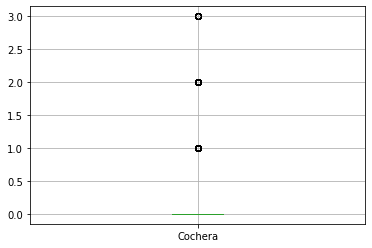

In [38]:
# Eliminamos outliers:
df_clean = df_clean[df_clean.Cochera <= 3.5]
df_clean.boxplot("Cochera")

In [67]:
df_clean["Cochera"].value_counts()

0.0    2793
1.0     529
2.0     224
3.0      16
Name: Cochera, dtype: int64

In [68]:
df_clean["sin_cochera"] = df_clean["Cochera"].apply(lambda x: 1 if x == 0 else 0)
df_clean["con_cochera"] = df_clean["Cochera"].apply(lambda x: 1 if x > 0 else 0)

df_clean.drop(columns=["sin_cochera"], inplace=True)

In [70]:
df_clean["con_cochera"] = df_clean["Cochera"].apply(lambda x: 1 if x > 0 else 0)

In [75]:
df_clean.drop(columns=["sin_cochera"], inplace=True)

# Distrito

Agrupamos los distritos en zonas segun el Apeim.


In [39]:
df_clean["Distrito"].value_counts()

Miraflores                 1118
Santiago de Surco           523
San Isidro                  454
Barranco                    210
San Borja                   174
San Miguel                  150
La Molina                   121
Magdalena del Mar           116
Lince                       107
Surquillo                   100
Jesus Maria                  88
Cercado de Lima              71
Chorrillos                   63
Pueblo Libre                 61
Los Olivos                   33
Ate                          27
San Martin de Porres         27
Breña                        19
San Juan de Miraflores       17
San Juan de Lurigancho       15
La Victoria                  14
Comas                        11
El Agustino                   8
San Bartolo                   7
Chaclacayo                    6
Puente Piedra                 5
San Luis                      5
Villa El Salvador             4
Santa Anita                   4
Villa Maria del Triunfo       4
Punta Hermosa                 4
Carabayl

In [40]:
def zonas(dist):
    if dist in ["Puente Piedra", "Comas", "Carabayllo", "Ventanilla"]:
        return 1
    elif dist in ["Independencia","Los Olivos", "San Martin de Porres"]:
        return 2
    elif dist in ["San Juan de Lurigancho"]: 
        return 3
    elif dist in ["Cercado de Lima", "Rimac", "Breña", "La Victoria"]: 
        return 4
    elif dist in ["Ate", "Chaclacayo", "Lurigancho", "Santa Anita", "San Luis", "El Agustino"]: 
        return 5
    elif dist in ["Jesus Maria", "Lince", "Pueblo Libre", "Magdalena del Mar", "San Miguel"]: 
        return 6
    elif dist in ["Miraflores", "San Isidro", "San Borja", "Santiago de Surco", "La Molina"]: 
        return 7
    elif dist in ["Surquillo", "Barranco", "Chorrillos", "San Juan de Miraflores"]: 
        return 8
    elif dist in ["Villa El Salvador", "Villa Maria del Triunfo", "Lurin", "Pachacamac"]: 
        return 9
    elif dist in ["Callao", "Bellavista", "La Perla", "La Punta", "Carmen de la Legua"]: 
        return 10
    else:
        # Otros distritos
        return 11

In [41]:
df_clean["zona"] = df_clean["Distrito"].apply(zonas)

Eliminamos los distritos que pertecen a la zona 11 (otros) por que no pertenecen a Lima Metropolitana

In [42]:
df_clean = df_clean[df_clean["zona"] < 11]

In [43]:
df_clean["zona"].value_counts()

7    2390
6     522
8     390
4     106
2      61
5      50
1      19
3      15
9       9
Name: zona, dtype: int64

# Correlaciones de variables

Aplicaremos la Correlacion de Pearson para saber la relación entre las variables.

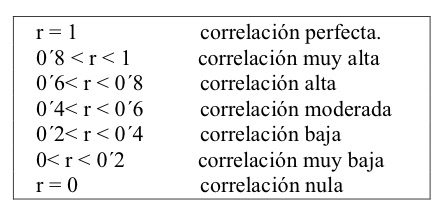

En base a esta imagen podemos determinar que tan fuerte es la correlacion entre variables.

               Precio  NCuartos      Area    NBaños   Cochera  con_cochera
Precio       1.000000  0.361833  0.689211  0.534202  0.188175     0.109424
NCuartos     0.361833  1.000000  0.528572  0.624503  0.092904     0.043027
Area         0.689211  0.528572  1.000000  0.569136  0.190668     0.101657
NBaños       0.534202  0.624503  0.569136  1.000000  0.186621     0.126419
Cochera      0.188175  0.092904  0.190668  0.186621  1.000000     0.916973
con_cochera  0.109424  0.043027  0.101657  0.126419  0.916973     1.000000


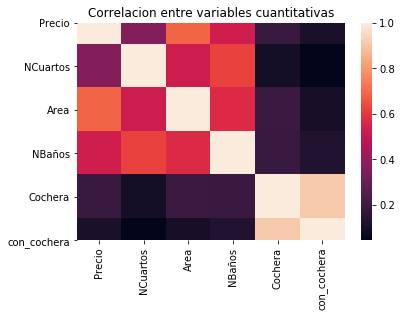

In [77]:
columnas_cuant = ["Precio", "NCuartos", "Area", "NBaños", "Cochera", "con_cochera"]
print(df_clean[columnas_cuant].corr())

sns.heatmap(df_clean[columnas_cuant].corr())
plt.title("Correlacion entre variables cuantitativas")
plt.show()

Realizamos graficos Scatterplot aplicando la correlación de pearson:

In [87]:
for col in columnas_cuant:
    df_clean.scatter(["Precio"])
    plt.title("")
    plt.show()

AttributeError: 'DataFrame' object has no attribute 'scatter'

# ANOVA Testing

Importamos la libreria para aplicar Anova:

In [46]:
import scipy.stats as stats

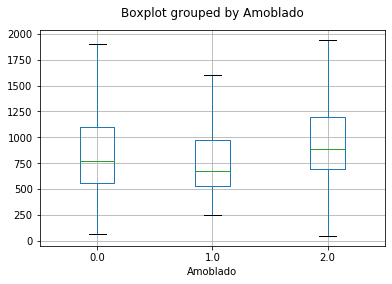

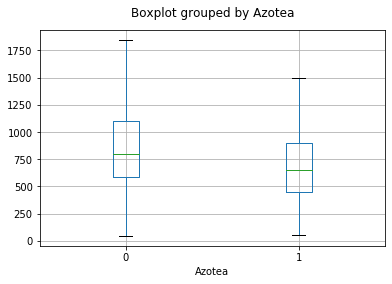

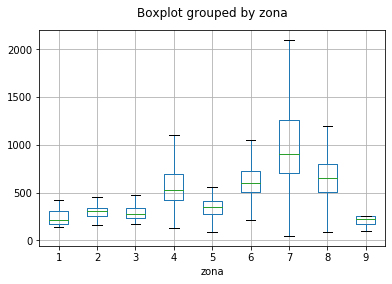

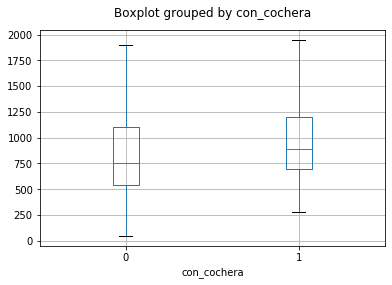

In [82]:
columnas_cual = ["Amoblado", "Azotea", "zona", "con_cochera"]

for col in columnas_cual:
    df_clean.boxplot(["Precio"], by=col, showfliers=False)
    if col == "Distrito":
        plt.xticks([])
    plt.title("")
    plt.show()

### ANOVA - Amoblado

In [47]:
f, p = stats.f_oneway(df_clean[df_clean["Amoblado"] == 0]["Precio"],df_clean[df_clean["Amoblado"] == 1]["Precio"],df_clean[df_clean["Amoblado"] ==2]["Precio"])
print("{0:.15f}".format(p))

0.000034399161523


### ANOVA - Azotea

In [48]:
f, p  = stats.f_oneway(df_clean[df_clean["Azotea"] == 0]["Precio"],df_clean[df_clean["Azotea"] == 1]["Precio"])
print("{0:.15f}".format(p))

0.000002003345330


### ANOVA - Zona

In [65]:
f,p = stats.f_oneway(df_clean[df_clean["zona"] == 1]["Precio"],
                      df_clean[df_clean["zona"] == 2]["Precio"],
                      df_clean[df_clean["zona"] == 3]["Precio"],
                      df_clean[df_clean["zona"] == 4]["Precio"],
                      df_clean[df_clean["zona"] == 5]["Precio"],
                      df_clean[df_clean["zona"] == 6]["Precio"],
                      df_clean[df_clean["zona"] == 7]["Precio"],
                      df_clean[df_clean["zona"] == 8]["Precio"],
                      df_clean[df_clean["zona"] == 9]["Precio"])
print(p)

8.393494089362707e-167


### ANOVA - Con cochera

In [79]:
f,p = stats.f_oneway(df_clean[df_clean["con_cochera"] == 0]["Precio"],
                      df_clean[df_clean["con_cochera"] == 1]["Precio"])
print(p)

5.828745412343266e-11


Las variables anteriormente analizadas pueden ser utilizadas, ya que demuestran una correlación con la variable "Precio", teniendo un valo p-value menor a 0.05. 

Por otro lado, si queremos usar la correlación de Pearson para ver la correlación entre la variable objetivo (Precio) y las variables cualitativas, podemos ver un resultado diferente. El resultado acertado seria el brindado por el ANOVA.

             Amoblado    Azotea      zona  con_cochera    Precio
Amoblado     1.000000  0.129712  0.122368     0.340581  0.059875
Azotea       0.129712  1.000000 -0.099995     0.046217 -0.079541
zona         0.122368 -0.099995  1.000000     0.121152  0.274531
con_cochera  0.340581  0.046217  0.121152     1.000000  0.109424
Precio       0.059875 -0.079541  0.274531     0.109424  1.000000


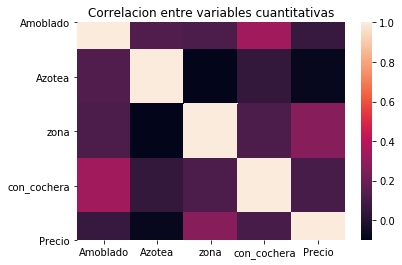

In [86]:
columnas_cual.append("Precio")
print(df_clean[columnas_cual].corr())
sns.heatmap(df_clean[columnas_cual].corr())
plt.title("Correlacion entre variables cuantitativas")
plt.show()

In [88]:
df_clean.to_csv("clean_data.csv")